In [1]:
# So this file will import the digit prediction model we just created and use it to discern numbers that are within 
# the shapes we specify. This file's job is to figure out what we want to feed to said model. 

# Import modules
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import cv2

# Load the digit identification model
model = tf.keras.models.load_model('digit_model')

In [7]:
# First lets make a function to clean the input image. 
def clean_image(path, thresh):
    # lets import the image with openCV, then apply a theshold filter on it. 
    # This will zero all pixels below a specified value
    gray = cv2.imread(path, 0)
    negative = abs(gray.max()-gray)
    clean_img = cv2.threshold(negative, thresh, 255, cv2.THRESH_BINARY)[1]
    return clean_img

In [3]:
# Next lets define a function that uses connected components labeling to find pixels that are combined into a structure. 
# This seems more robust than training a model to identify shapes. 
# Once we find said shapes, we want this function to spit out the pixel boundaries for shapes that lie within others (our numbers hopefully).
# There are many edge cases for this scenario like:
# non-digits within shapes, shapes that touch the numbers, muilti-character digits, shapes within shapes...
# but we will assume we are being fed a good image like the one provided.

def valid_nums(img):
    # Take in the image, use connected components labeling to identify all connected shapes with stats
    connectivity = 4
    connect = cv2.connectedComponentsWithStats(img, connectivity, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = connect
    
    # Find the pixel boundaries and centroids for each component
    borders = [] #Bounding box dimensions
    center = [] #Centroids
    for val in range(1, len(stats)): #borders = [minx, maxx, miny, maxy]
        borders.append([stats[val][0], stats[val][0]+stats[val][2], stats[val][1], stats[val][1]+stats[val][3]])
        center.append(centroids[val])
    val_nums = []
    
    # Iterate through each component identified and check if it lies within another
    for count1, val1 in enumerate(borders):
        for count2, val2 in enumerate(borders):
            # If it does lie within another component, add its borders to an image with a 5 pixel buffer on each side
            if (val2[0] < val1[0]) & (val2[1] > val1[1]) & (val2[2] < val1[2]) & (val2[3] > val1[3]) & (count1 != count2):
                val_nums.append([val1[0]-5, val1[1]+5, val1[2]-5, val1[3]+5, center[count1][0], center[count1][1]])
                
    # Now that we have the components within other ones, lets make a tensor of all valid pixels in the image.
    output_nums = []
    cent = []
    for bounds in val_nums:
        cent.append(bounds[4:]) 
        temp = [] # just a temporary holder for the pixel rows
        for row in img[bounds[2]:bounds[3]+1]: # iterate through the pixel rows, save in temp
            temp.append(row[bounds[0]:bounds[1]])
        
        # Now lets convert this to a tensor and re-size for our digit identifying model
        temp = tf.convert_to_tensor(temp)[tf.newaxis,...,tf.newaxis]
        temp = tf.image.resize(temp, [28,28])[0,...,0]
        output_nums.append(temp)
    
    # Stack all the tensors together, with the first axis as batch#
    output_nums = tf.stack(output_nums, axis=0)
    return tf.keras.utils.normalize(output_nums, axis=1), cent  # normalized pixels of digits returned, image centroids

In [5]:
# Almost there! Now we just make a function that makes a prediction on the pixels we feed to it. 
def prediction(nums, centroids, image):
    
    pred = model.predict([nums]) # Make prediction on the normalized tensor.
    pred_val = [np.argmax(a) for a in pred]
    print("Numbers that lie within shapes, top to bottom...")
    for count, val in enumerate(pred_val):
        print(f'Number prediction: {val}, Pixel[X, Y]: {centroids[count]}')
    
    # Print the negative of the image along with the valid number centroid locations
    x, y = [], []
    for center in centroids:
        x.append(center[0])
        y.append(center[1])
        
    plt.figure(figsize=(8,8))
    plt.imshow(image, cmap ='gray') # Import the image
    plt.plot(x, y, marker='+', markersize=18)
    plt.xlabel('X-axis Pixels', fontsize=12)
    plt.ylabel('Y-axis Pixels', fontsize=12)
    plt.show() # Plot the image
    

Numbers that lie within shapes, top to bottom...
Number prediction: 4, Pixel[X, Y]: [162.2396449704142, 195.9852071005917]
Number prediction: 8, Pixel[X, Y]: [589.9546925566343, 303.3851132686084]
Number prediction: 3, Pixel[X, Y]: [171.71212121212122, 546.780303030303]


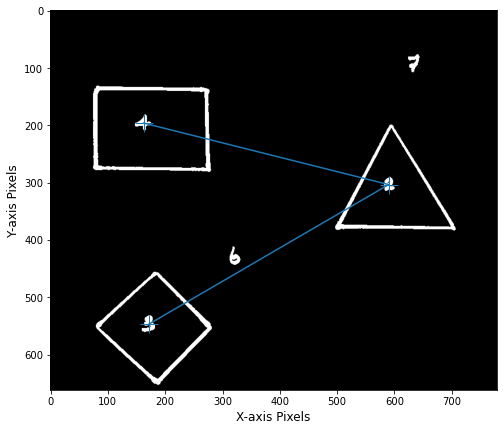

In [8]:
# Just input the image file name in the directory we are interested in and we are off. 
# Based on the image background the threshold pixel intensity might need to be played with, but 125 works for this case.
image = clean_image('Test_image.jpg', 125)

# These will take care of the rest!
valid_numbers, centroids = valid_nums(image)
prediction(valid_numbers, centroids, image)